## generate_data.py

In [23]:
import csv
import random
from datetime import datetime, timedelta
import json

# Generate data for 50 characters
NUM_ROWS = 1000

# Create the CSV file
OUTPUT_FILE = "troop_movements.csv"


def choose_a_side(home_world):
    """
    Randomly choose an empire or resistance side based on the likelihood 
    that someone from that world would join the rebel alliance.
    Args:
        home_world (dict): The home world data for the character.
    Returns:
        str: The empire or resistance side.
    """
    if home_world["rebel_likelihood"] > random.random():
        return "resistance"
    else:
        return "empire"


# Load home world data from JSON file
with open("home_worlds.json") as json_file:
    home_worlds = json.load(json_file)

# Generate data rows
data_rows = []
for i in range(1, NUM_ROWS + 1):
    # Generate random values for each column
    timestamp = datetime.now() - timedelta(seconds=i)
    unit_id = i
    unit_type = random.choice(
        ["stormtrooper", "tie_fighter", "at-st", "x-wing",
            "resistance_soldier", "at-at", "tie_silencer", "unknown"]
    )
    location_x = random.randint(1, 10)
    location_y = random.randint(1, 10)
    destination_x = random.randint(1, 10)
    destination_y = random.randint(1, 10)

    # Select a random home world from the available options
    home_world = random.choice(home_worlds)
    home_world_name = home_world["name"]
    empire_or_resistance = choose_a_side(home_world)

    # Create the data row
    data_row = [
        timestamp.strftime("%Y-%m-%d %H:%M:%S"),
        unit_id,
        unit_type,
        empire_or_resistance,
        location_x,
        location_y,
        destination_x,
        destination_y,
        home_world_name,
    ]

    # Add the data row to the list
    data_rows.append(data_row)

# Write the data to the CSV file
with open(OUTPUT_FILE, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(
        ["timestamp", "unit_id", "unit_type", "empire_or_resistance", "location_x", "location_y", "destination_x",
         "destination_y", "homeworld"]
    )
    writer.writerows(data_rows)

print("Data generation complete.")


Data generation complete.


### Display troop_movements.csv as DataFrame

In [24]:
import pandas as pd
df = pd.read_csv("troop_movements.csv")
print(df)

,timestamp,unit_id,unit_type,empire_or_resistance,location_x,location_y,destination_x,destination_y,homeworld
0,2024-02-07 10:52:22,1,x-wing,resistance,7,9,7,5,Bestine IV
1,2024-02-07 10:52:21,2,resistance_soldier,empire,4,2,2,2,Dorin
2,2024-02-07 10:52:20,3,tie_silencer,empire,8,8,2,3,Dathomir
3,2024-02-07 10:52:19,4,tie_fighter,empire,6,6,10,7,Iktotch
4,2024-02-07 10:52:18,5,resistance_soldier,empire,10,9,9,3,Dorin
...,...,...,...,...,...,...,...,...,...
995,2024-02-07 10:35:47,996,tie_silencer,empire,4,10,1,1,Bestine IV
996,2024-02-07 10:35:46,997,at-at,resistance,2,8,10,4,Zolan
997,2024-02-07 10:35:45,998,tie_silencer,resistance,4,4,5,3,Ryloth
998,2024-02-07 10:35:44,999,tie_silencer,empire,1,2,3,1,Malastare


### Part 2: Build a prediction model

In [25]:
# Create grouped data showing counts of empire vs resistance.
er = df.groupby("empire_or_resistance").size().reset_index(name="count")
print(er.head())

  empire_or_resistance  count
0               empire    506
1           resistance    494


In [26]:
# Create grouped data showing counts of characters by homeworld
homeworld_counts = df.groupby("homeworld").size().reset_index(name="count")
print(homeworld_counts.head())


     homeworld  count
0     Alderaan     17
1  Aleen Minor     23
2   Bestine IV     35
3        Cerea     22
4     Champala     23


In [27]:
# Created grouped data showing counts of characters by unit_type
unit_type_counts = df.groupby("unit_type").size().reset_index(name="count")
print(unit_type_counts.head())


            unit_type  count
0               at-at    125
1               at-st    124
2  resistance_soldier    131
3        stormtrooper    112
4         tie_fighter    122


In [28]:
# Engineer a new feature called is_resistance with a True or False value based on empire_or_resiatance
df['is_resistance'] = df["empire_or_resistance"].map(lambda x: x == "resistance")
df.head()

,timestamp,unit_id,unit_type,empire_or_resistance,location_x,location_y,destination_x,destination_y,homeworld,is_resistance
0,2024-02-07 10:52:22,1,x-wing,resistance,7,9,7,5,Bestine IV,True
1,2024-02-07 10:52:21,2,resistance_soldier,empire,4,2,2,2,Dorin,False
2,2024-02-07 10:52:20,3,tie_silencer,empire,8,8,2,3,Dathomir,False
3,2024-02-07 10:52:19,4,tie_fighter,empire,6,6,10,7,Iktotch,False
4,2024-02-07 10:52:18,5,resistance_soldier,empire,10,9,9,3,Dorin,False


<Axes: xlabel='empire_or_resistance', ylabel='count'>

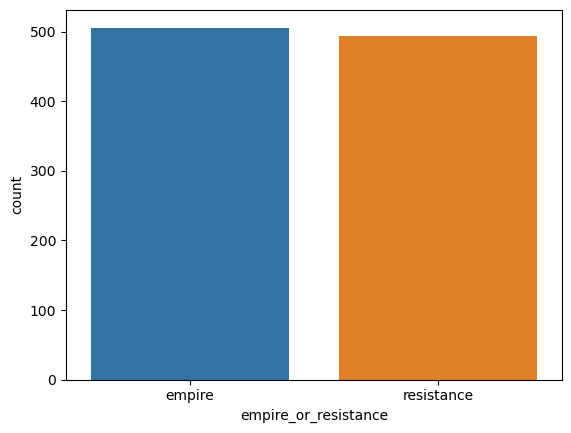

In [29]:
# Create a bar plot using Seaborn showing Empire vs Resistance distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x = 'empire_or_resistance',y='count',data = er)

In [30]:
# Create a prediction model using sklearn.tree.DecisionTreeClassifier that predicts if a character is joining either the Empire or the Resistance based on their homeworld and unit_type.
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

In [31]:
features = ["homeworld","unit_type"]
# Convert categorical features to numeric using pd.get_dummies. 
df1 = df.copy()
X_encoded = pd.get_dummies(df[features])
y_encoded = pd.get_dummies(df['empire_or_resistance'])

In [32]:

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.15, random_state=1)

model = DecisionTreeClassifier()
model = model.fit(X_train,y_train)

y_pred = model.predict(X_test)
print(y_pred)

array([[0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0,

                         Feature  Importance
0             homeworld_Alderaan    0.032348
1          homeworld_Aleen Minor    0.003241
2           homeworld_Bestine IV    0.008926
3                homeworld_Cerea    0.003416
4             homeworld_Champala    0.002029
5            homeworld_Chandrila    0.051620
6         homeworld_Concord Dawn    0.014421
7             homeworld_Corellia    0.042608
8              homeworld_Dagobah    0.009892
9             homeworld_Dathomir    0.009530
10               homeworld_Dorin    0.012172
11              homeworld_Eriadu    0.006090
12         homeworld_Glee Anselm    0.000800
13          homeworld_Haruun Kal    0.008779
14             homeworld_Iktotch    0.010449
15            homeworld_Iridonia    0.010067
16               homeworld_Kalee    0.002945
17            homeworld_Kashyyyk    0.014655
18           homeworld_Malastare    0.011756
19              homeworld_Mirial    0.022801
20            homeworld_Mon Cala    0.031166
21        

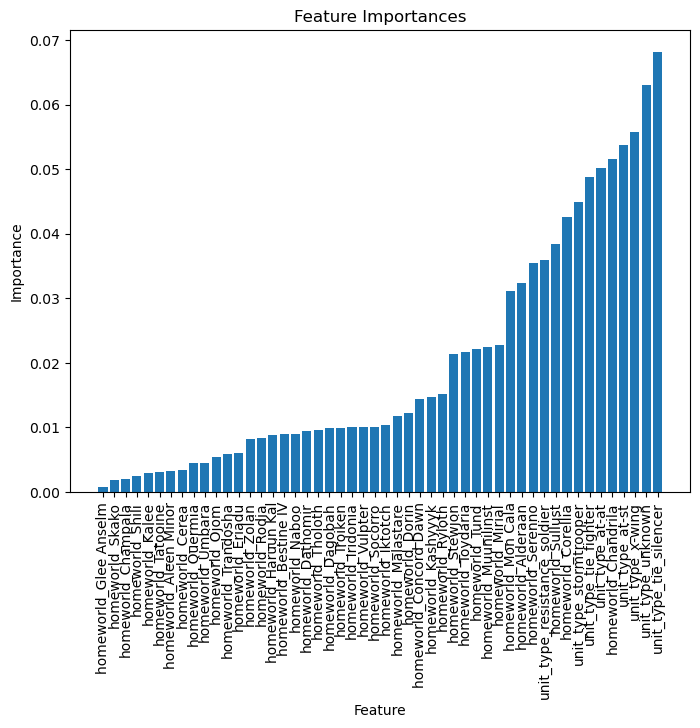

In [34]:
# Get feature importances
importances = model.feature_importances_

# Create a DataFrame to hold the feature importances
feature_importances = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': importances})
print(feature_importances)
feature_importances = feature_importances.sort_values('Importance', ascending=True)

# Create a bar plot that shows feature importance.
plt.figure(figsize=(8, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

In [35]:
# Save to model as a pickle file named trained_model.pkl
import pickle
filename = "trained_model.pkl"
with open(filename, 'wb') as file:
      pickle.dump(model, file)

### Part 3: Use the trained model with “real” data

Load data from troop_movements10m.csv (see Guided Project zip for file). This file contains 10 million records to be predicted. 
This data must be cleaned up a bit before it can be used:

⦁	Some unit_type records have a value of invalid_unit. Replace that with unknown.

⦁	Some location_x and location_Y values are missing. Use the ffill method to fill.

⦁	Save the clean data into a Parquet file named troop_movements10m.parquet.

⦁	You need to install pyarrow and fastparquet to support saving to a Parquet file.

pip install pyarrow

pip install fastparquet

Load the pickled model and load the data from the Parquet file into a data frame. Run the data through the model.


In [44]:
df_trained = pd.read_csv('troop_movements.csv')

In [37]:
%pip install pyarrow

In [38]:
%pip install fastparquet

Note: you may need to restart the kernel to use updated packages.


In [45]:
df_trained

,timestamp,unit_id,unit_type,empire_or_resistance,location_x,location_y,destination_x,destination_y,homeworld
0,2024-02-07 10:52:22,1,x-wing,resistance,7,9,7,5,Bestine IV
1,2024-02-07 10:52:21,2,resistance_soldier,empire,4,2,2,2,Dorin
2,2024-02-07 10:52:20,3,tie_silencer,empire,8,8,2,3,Dathomir
3,2024-02-07 10:52:19,4,tie_fighter,empire,6,6,10,7,Iktotch
4,2024-02-07 10:52:18,5,resistance_soldier,empire,10,9,9,3,Dorin
...,...,...,...,...,...,...,...,...,...
995,2024-02-07 10:35:47,996,tie_silencer,empire,4,10,1,1,Bestine IV
996,2024-02-07 10:35:46,997,at-at,resistance,2,8,10,4,Zolan
997,2024-02-07 10:35:45,998,tie_silencer,resistance,4,4,5,3,Ryloth
998,2024-02-07 10:35:44,999,tie_silencer,empire,1,2,3,1,Malastare
